У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from darts import TimeSeries
from darts.utils.statistics import plot_pacf, check_seasonality
from darts.models import NaiveSeasonal, NaiveDrift, ExponentialSmoothing, AutoARIMA, Theta
from darts.metrics import mape

In [50]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [5]:
df = pd.read_csv('train.csv')

In [7]:
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [9]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True) 

In [11]:
df

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

Напишіть висновок з побудованих вами візуалізацій.

Підказка: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


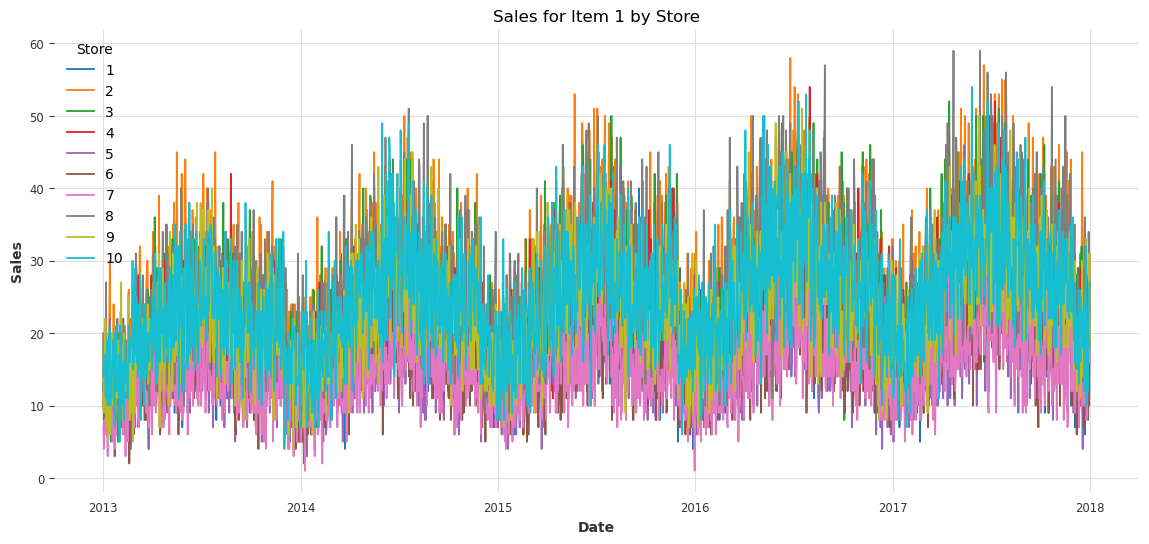

In [14]:
df_item_1 = df[(df['item'] == 1)]

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_item_1, x='date', y='sales', hue='store', palette='tab10')
plt.title('Sales for Item 1 by Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Store')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


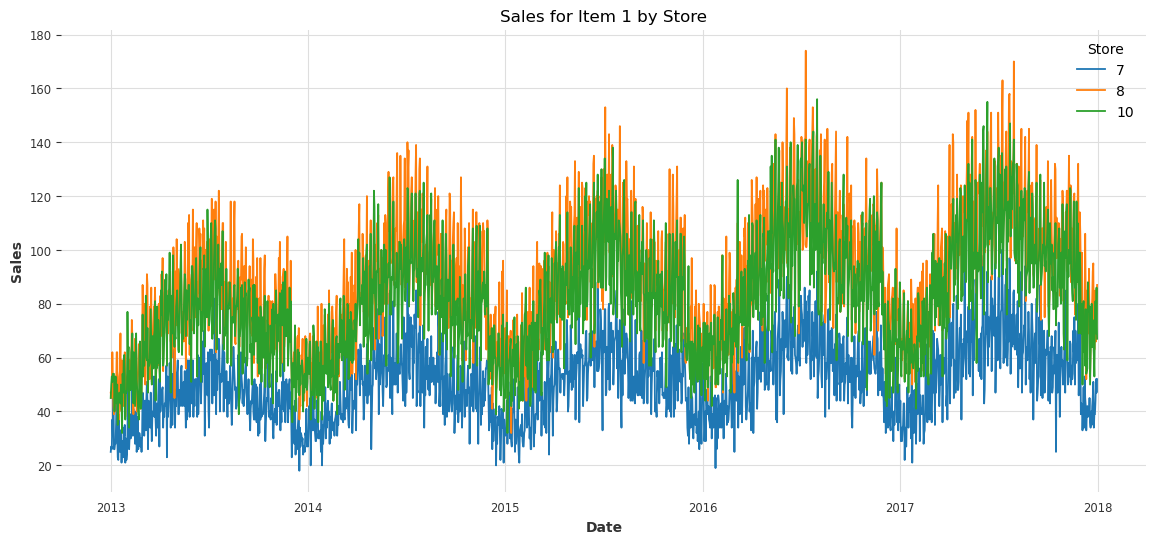

In [15]:
df_item_10 = df[(df['item'] == 10) & ((df['store'] == 7)|(df['store'] == 10)|(df['store'] == 8))]

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_item_10, x='date', y='sales', hue='store', palette='tab10')
plt.title('Sales for Item 1 by Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Store')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


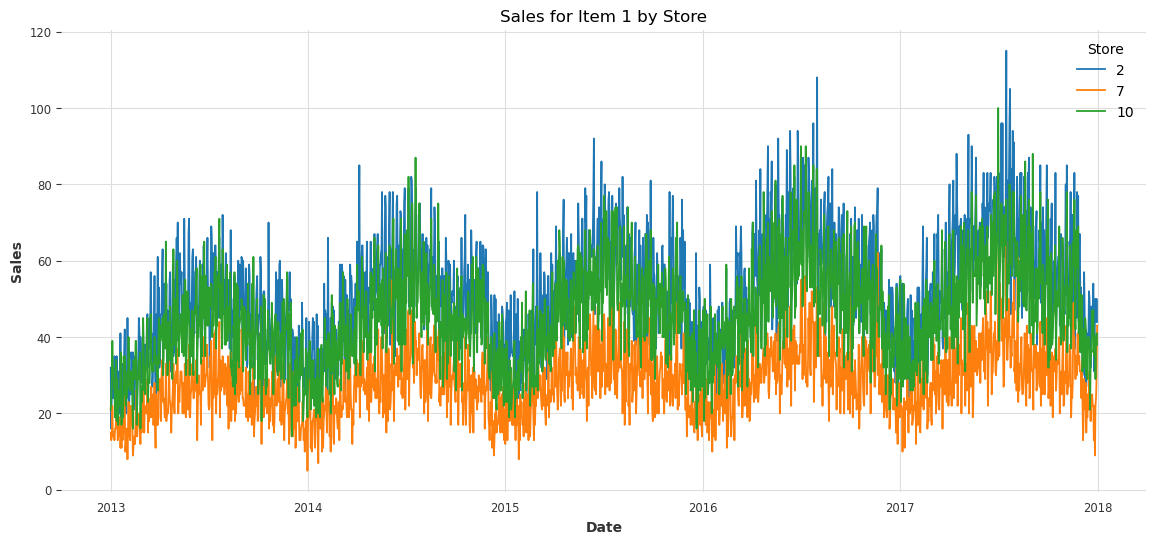

In [16]:
df_item_30 = df[(df['item'] == 30) & ((df['store'] == 7)|(df['store'] == 10)|(df['store'] == 2))]

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_item_30, x='date', y='sales', hue='store', palette='tab10')
plt.title('Sales for Item 1 by Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Store')
plt.show()

На графіках чітко видно, що динаміка приблизно однакова, а обʼєми продажів різні.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [22]:
df_item_1_store_1 = df[(df['item'] == 1) & (df['store'] == 1)]

In [24]:
df_item_1_store_1

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,1,1,14
2017-12-28,1,1,19
2017-12-29,1,1,15


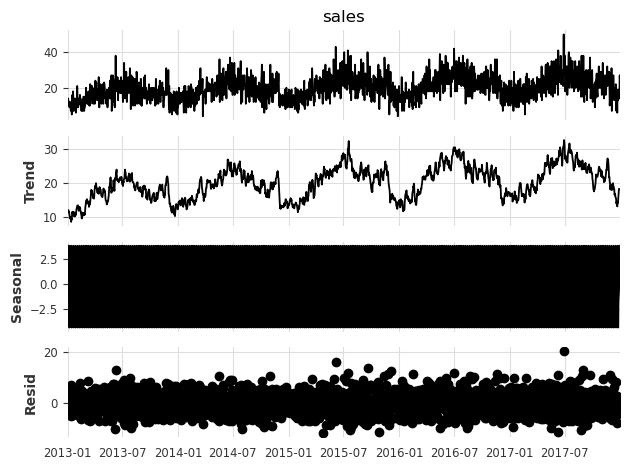

In [26]:
decomposition_plot_multi = seasonal_decompose(df_item_1_store_1['sales'],
                                              model='additive')
decomposition_plot_multi.plot()
plt.show()

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [29]:
series = TimeSeries.from_dataframe(df_item_1_store_1, value_cols='sales')

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [32]:
train_data, val_data = series.split_before(pd.Timestamp('2017-10-01'))

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

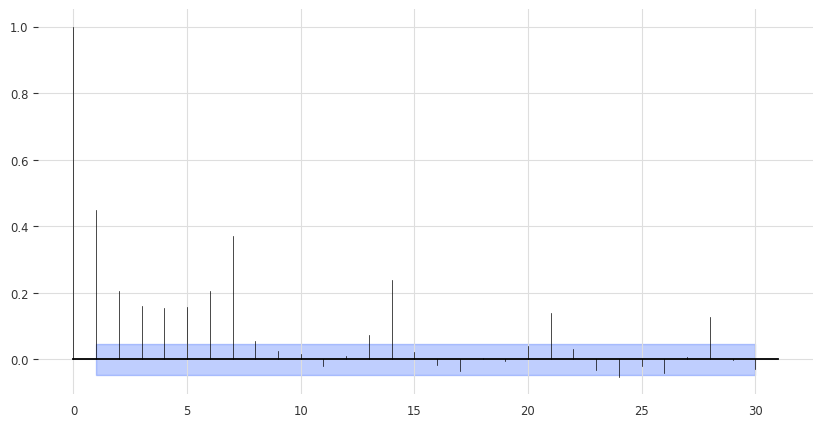

In [35]:
plot_pacf(series, max_lag=30)

до 7 лагу, 14, 21, 28 лаги мають значення. бачимо тижневу сезонність

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [39]:
check_seasonality(series)

(True, 7)

In [41]:
is_seasonal, seasonality_period = check_seasonality(series, m=28, max_lag=30)

In [43]:
is_seasonal

True

In [45]:
seasonality_period

28

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

<Axes: xlabel='date'>

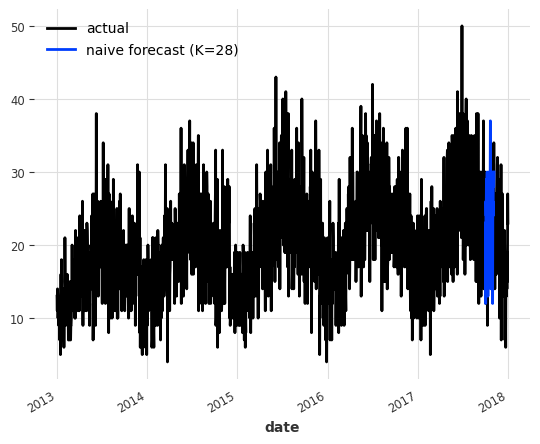

In [48]:
naive_model = NaiveSeasonal(K=28)
naive_model.fit(train_data)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=28)")

<Axes: xlabel='date'>

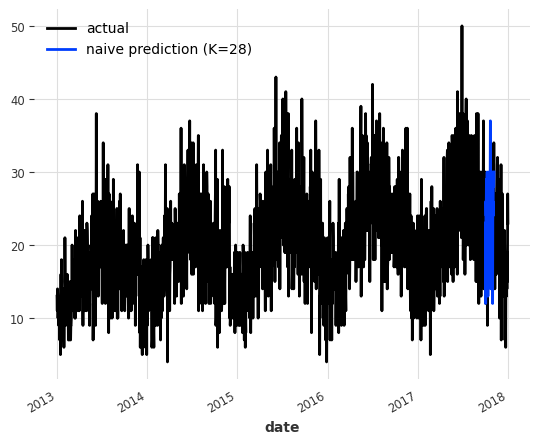

In [52]:
seasonal_model = NaiveSeasonal(K=28)
seasonal_model.fit(train_data)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=28)")

<Axes: xlabel='date'>

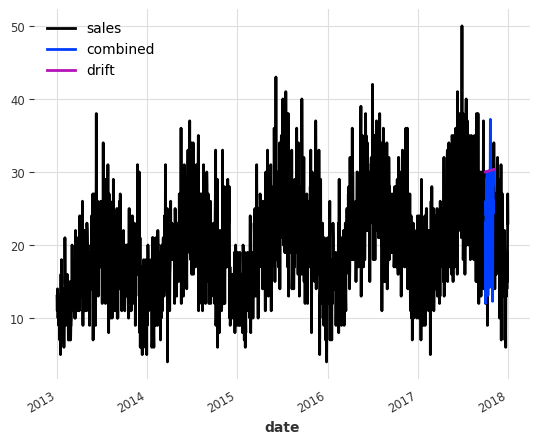

In [54]:
drift_model = NaiveDrift()
drift_model.fit(train_data)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train_data.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [57]:
print(
    f"Mean absolute percentage error for the combined naive drift + seasonal (Naive_Drift): {mape(series, combined_forecast):.2f}%."
)
print(
    f"Mean absolute percentage error for the combined naive_forecast: {mape(series, naive_forecast):.2f}%."
)
print(
    f"Mean absolute percentage error for the combined seasonal_forecast: {mape(series, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal (Naive_Drift): 29.67%.
Mean absolute percentage error for the combined naive_forecast: 29.33%.
Mean absolute percentage error for the combined seasonal_forecast: 29.67%.


У всіх випадках достатньо велика помилка.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [61]:
df_columns = pd.read_csv('train.csv')

In [63]:
df_columns['date'] = pd.to_datetime(df_columns['date'], format='%Y-%m-%d')

df_columns['year'] = df_columns['date'].dt.year
df_columns['month'] = df_columns['date'].dt.month
df_columns['day'] = df_columns['date'].dt.day
df_columns['day_of_week'] = df_columns['date'].dt.dayofweek  # Monday=0, Sunday=6
df_columns['day_of_year'] = df_columns['date'].dt.dayofyear
df_columns['week_of_year'] = df_columns['date'].dt.isocalendar().week  # ISO week number
df_columns['quarter'] = df_columns['date'].dt.quarter
df_columns['is_month_start'] = df_columns['date'].dt.is_month_start.astype(int)  
df_columns['is_month_end'] = df_columns['date'].dt.is_month_end.astype(int)

us_holidays = holidays.US() 
df_columns['is_holiday'] = df_columns['date'].isin(us_holidays).astype(int)

In [65]:
df_columns.columns

Index(['date', 'store', 'item', 'sales', 'year', 'month', 'day', 'day_of_week',
       'day_of_year', 'week_of_year', 'quarter', 'is_month_start',
       'is_month_end', 'is_holiday'],
      dtype='object')

In [67]:
X = df_columns.drop(columns=['sales', 'date']) 
y = df_columns['sales']  

X_train_XG, X_test_XG, y_train_XG, y_test_XG = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [69]:
model = XGBRegressor(objective='reg:squarederror', random_state=42)

model.fit(X_train_XG, y_train_XG)

y_pred = model.predict(X_test_XG)

In [70]:
mape = mean_absolute_percentage_error(y_test_XG, y_pred)

In [71]:
mape

0.3911423358552567

Модель вийшла гірша за попередні

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [77]:
from darts.metrics import mape

def eval_forecast(model_name, val, forecast):
    mape_ = mape(val, forecast)
    print(f"Model {model_name} obtains MAPE: {mape_:.2f}%")
    return mape_

def fit_eval_model(model):
    model_name = model.__class__.__name__  
    model.fit(train_data)
    forecast = model.predict(len(val_data))  
    eval_forecast(model_name, val_data, forecast)


fit_eval_model(ExponentialSmoothing())
fit_eval_model(AutoARIMA())

Model ExponentialSmoothing obtains MAPE: 39.01%
Model AutoARIMA obtains MAPE: 39.19%


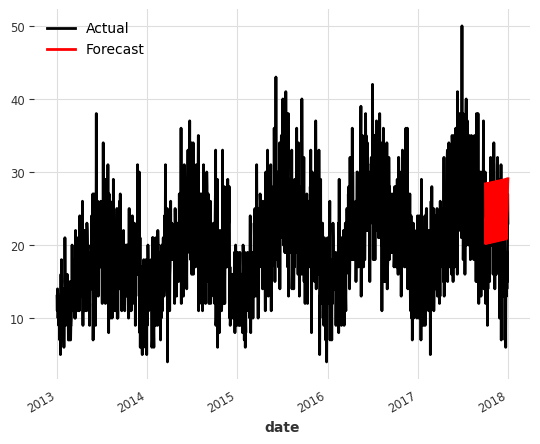

Model ExponentialSmoothing() obtains MAPE: 39.01%


In [78]:
def plot_results(series, forecast):
  # Візуалізація результатів
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

model = ExponentialSmoothing()
fit_and_plot(model, series, train_data, val_data)

12. Натренуйте модель ARIMA, параметри оберіть самостійно. Зробіть висновок про її якість.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


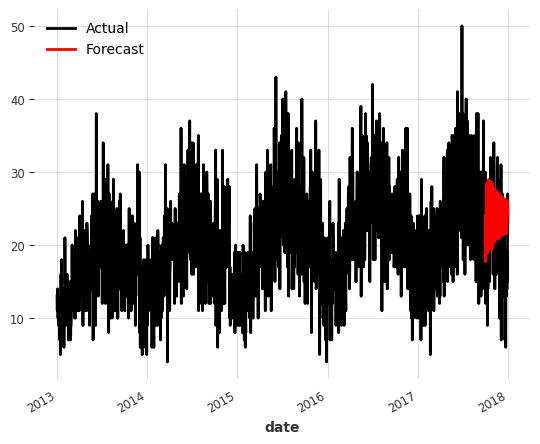

Model ARIMA(p=35, q=1) obtains MAPE: 36.11%


In [83]:
from darts.models import ARIMA

# Побудова та тренування моделі ARIMA
model = ARIMA(p=35, d=1, q=1)
fit_and_plot(model, series, train_data, val_data)

Результати гірші, ніж у наївних передбачень. NaiveSeasonal поки виявилась найкращою

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

AutoARIMA(add_encoders=None, start_p=7, max_p=25, start_q=1)

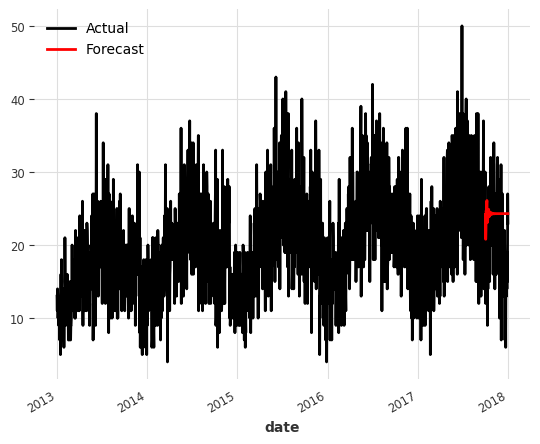

In [85]:
# Побудова та тренування моделі AutoArima
model = AutoARIMA(start_p=7, max_p=25, start_q=1) 
model.fit(train_data)

display(model)

# Прогнозування
forecast = model.predict(len(val_data))

# Візуалізація результатів
plot_results(series, forecast)

In [86]:
eval_forecast(model, val_data, forecast);

Model AutoARIMA(start_p=7, max_p=25, start_q=1) obtains MAPE: 39.53%


14. Натренуйте модель Prophet та зробіть висновок про її якість.

17:03:51 - cmdstanpy - INFO - Chain [1] start processing
17:03:51 - cmdstanpy - INFO - Chain [1] done processing


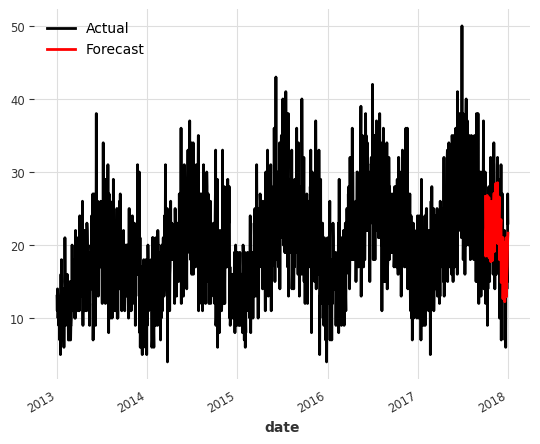

In [88]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(train_data)

# Прогнозування
forecast = model.predict(len(val_data))

# Візуалізація результатів
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [89]:
eval_forecast(model, val_data, forecast);

Model Prophet() obtains MAPE: 23.81%


Поки Prophet дає найкращий результат

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [ ]:
from darts.models import RNNModel

# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)
model.fit(train_data)

# Прогнозування
forecast = model.predict(len(val_data))

# Візуалізація результатів
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Відповідь:

1. Використовувала б найкращу модель. У нашому випадку найкраще себе показала Пропет.
2. 500 моделей. Виходить для кожного айтему і для кожного магазину.